In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
FILEPATH = "/data/cgm_to_meal.csv"
data = (pd.read_csv(FILEPATH, header=0))
data = data.dropna()
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
train_allData, test_allData = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train_allData), len(test_allData))

35752 3973


**Idea : CGM (predicted) - CGM (actual) > threshold to be categorized as meal event**

**Part 1 : Finding CGM (predicted)**

In [4]:
cgm_data = train_allData.cgm
# cgm_data_meal = train_allData(train_allData['meal'] == 1)]
cgm_data_no_meal = data[(data['meal'] == 0)]

# cgm_data_meal = cgm_data_meal.cgm
cgm_data_no_meal= cgm_data_no_meal.cgm
# print(cgm_data_no_meal)

In [5]:
train_size_cgm = int(len(cgm_data_no_meal) * 0.8)
test_size_cgm = len(cgm_data_no_meal) - train_size_cgm
train_cgm_no_meal, test_cgm_no_meal = cgm_data_no_meal.iloc[0:train_size_cgm], cgm_data_no_meal.iloc[train_size_cgm:len(cgm_data_no_meal)]
print(len(train_cgm_no_meal), len(test_cgm_no_meal))



31139 7785


In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [7]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train_cgm_no_meal, train_cgm_no_meal, time_steps)
X_test, y_test = create_dataset(test_cgm_no_meal, test_cgm_no_meal, time_steps)


X_train= X_train.reshape(len(X_train), 1, 1)
X_test= X_test.reshape(len(X_test), 1, 1)


print(X_train.shape, y_train.shape)
# X_test, y_test = create_dataset(test, test.cgm, time_steps)




(31138, 1, 1) (31138,)


In [10]:
print(X_train)
print(y_train)

[[[118.]]

 [[122.]]

 [[124.]]

 ...

 [[243.]]

 [[245.]]

 [[244.]]]
[122. 124. 126. ... 245. 244. 241.]


In [11]:
model_cgm = keras.Sequential()
model_cgm.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model_cgm.add(keras.layers.Dense(1))
model_cgm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model_cgm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_cgm = model_cgm.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Epoch 1/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.5092 - val_loss: 86.1684
Epoch 2/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.4449 - val_loss: 85.9966
Epoch 3/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.3817 - val_loss: 85.8164
Epoch 4/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.3198 - val_loss: 85.6291
Epoch 5/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.2594 - val_loss: 85.4352
Epoch 6/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.2001 - val_loss: 85.2349
Epoch 7/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.1423 - val_loss: 85.0288
Epoch 8/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.0857 - val_loss: 84.8168
Epoch 9/1000
876/876 [==============================] - 1s 1ms/step - loss: 139.0301 - val_loss: 84.5994
Epoch 10/1000
876/876 [==============================] 

876/876 [==============================] - 1s 1ms/step - loss: 137.3830 - val_loss: 97.6108
Epoch 79/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.3849 - val_loss: 97.7051
Epoch 80/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.3869 - val_loss: 97.8315
Epoch 81/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.3889 - val_loss: 97.9991
Epoch 82/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.3913 - val_loss: 98.2181
Epoch 83/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.3945 - val_loss: 98.4931
Epoch 84/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.3989 - val_loss: 98.8139
Epoch 85/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.4043 - val_loss: 99.1505
Epoch 86/1000
876/876 [==============================] - 1s 1ms/step - loss: 137.4094 - val_loss: 99.4639
Epoch 87/1000
876/876 [==============================] - 1s 

876/876 [==============================] - 1s 1ms/step - loss: 136.5371 - val_loss: 102.5811
Epoch 155/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.5184 - val_loss: 102.4447
Epoch 156/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.4994 - val_loss: 102.3135
Epoch 157/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.4798 - val_loss: 102.1880
Epoch 158/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.4592 - val_loss: 102.0707
Epoch 159/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.4373 - val_loss: 101.9667
Epoch 160/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.4129 - val_loss: 101.8860
Epoch 161/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.3831 - val_loss: 101.8376
Epoch 162/1000
876/876 [==============================] - 1s 1ms/step - loss: 136.3413 - val_loss: 101.6993
Epoch 163/1000
876/876 [===================

876/876 [==============================] - 1s 1ms/step - loss: 134.9924 - val_loss: 87.2234
Epoch 231/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.9816 - val_loss: 87.2460
Epoch 232/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.9934 - val_loss: 86.8123
Epoch 233/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.0978 - val_loss: 85.8229
Epoch 234/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2268 - val_loss: 85.6760
Epoch 235/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2060 - val_loss: 85.5885
Epoch 236/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.1914 - val_loss: 85.5101
Epoch 237/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.1799 - val_loss: 85.4392
Epoch 238/1000
876/876 [==============================] - 1s 994us/step - loss: 135.1689 - val_loss: 85.3749
Epoch 239/1000
876/876 [==========================

876/876 [==============================] - 1s 1ms/step - loss: 134.4648 - val_loss: 94.8185
Epoch 307/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.4959 - val_loss: 96.7533
Epoch 308/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.4156 - val_loss: 92.5577
Epoch 309/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.6364 - val_loss: 102.2146
Epoch 310/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.3002 - val_loss: 87.6166
Epoch 311/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.7062 - val_loss: 97.2806
Epoch 312/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.3793 - val_loss: 92.3361
Epoch 313/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.6797 - val_loss: 104.4876
Epoch 314/1000
876/876 [==============================] - 1s 1ms/step - loss: 134.4246 - val_loss: 87.8016
Epoch 315/1000
876/876 [==========================

876/876 [==============================] - 1s 1ms/step - loss: 135.1837 - val_loss: 116.5194
Epoch 383/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2085 - val_loss: 116.9581
Epoch 384/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2310 - val_loss: 117.3325
Epoch 385/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2505 - val_loss: 117.6373
Epoch 386/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2679 - val_loss: 117.8781
Epoch 387/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2823 - val_loss: 118.0490
Epoch 388/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.2949 - val_loss: 118.1471
Epoch 389/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.3047 - val_loss: 118.1527
Epoch 390/1000
876/876 [==============================] - 1s 1ms/step - loss: 135.3123 - val_loss: 118.0374
Epoch 391/1000
876/876 [===================

KeyboardInterrupt: 

In [20]:
y_pred = model_cgm.predict(X_test)

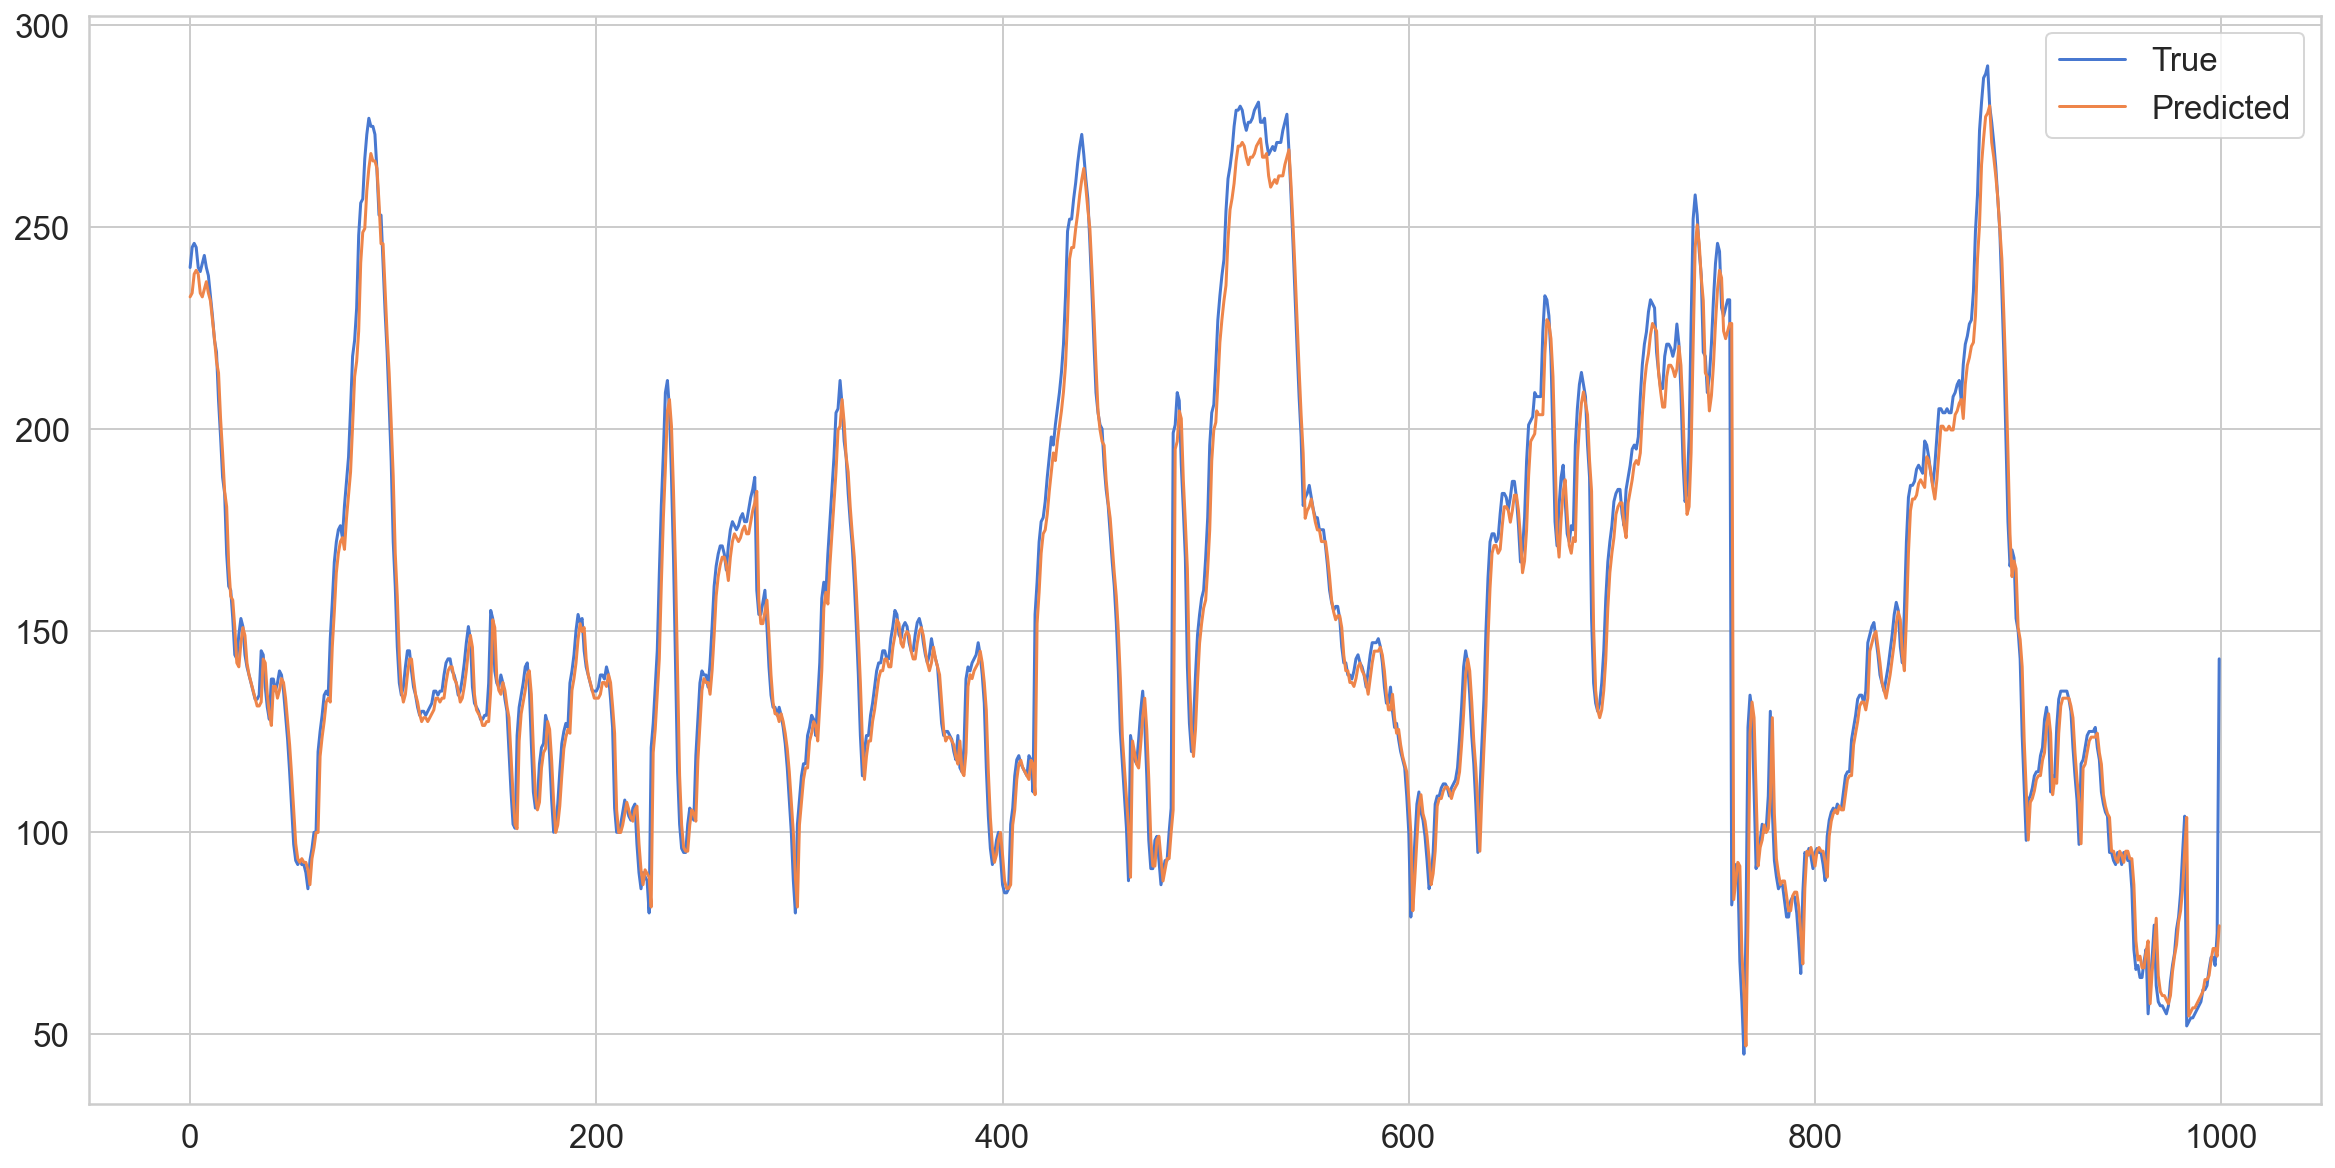

In [23]:
plot_points = 1000
start_idx = 1000
plt.figure(figsize=(20,10))
plt.plot(y_test[start_idx: start_idx + 1000], label='True')
plt.plot(y_pred[:1000], label='Predicted')
plt.legend()

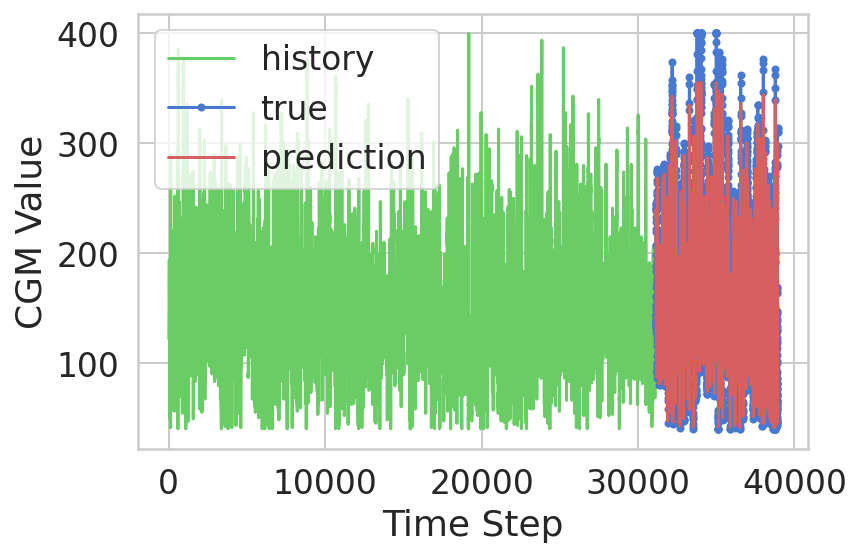

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('CGM Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

CGM predicted

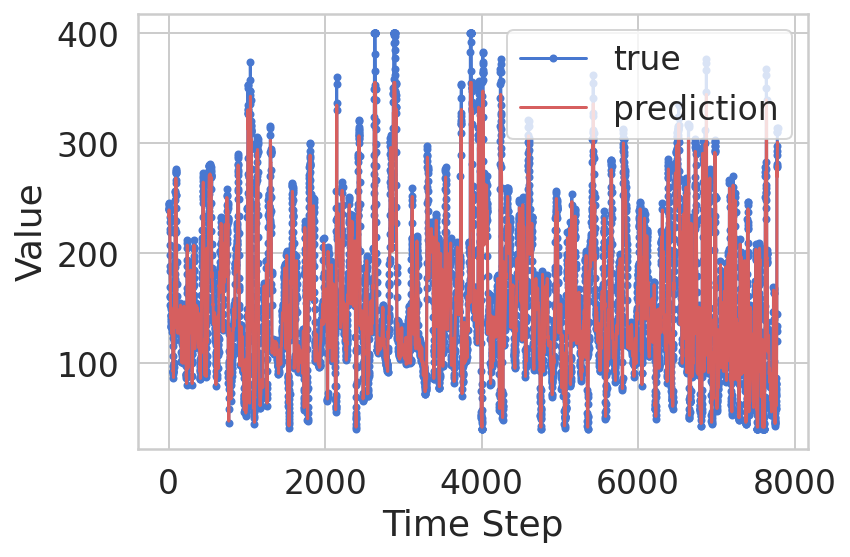

In [11]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

**Part 2: Finding actual CGM**

In [12]:
# print(test_allData)
# print("length of test data :", len(test_allData))

In [13]:
test_allData.meal.value_counts()

0    3888
1      85
Name: meal, dtype: int64

In [14]:
cgm_test = test_allData.cgm
# print(cgm_test)
cgm_test = np.array(cgm_test).reshape(len(cgm_test), 1, 1)
cgm_predicted = model_cgm.predict(cgm_test)
# print(cgm_predicted)
# print(len(cgm_predicted))

Find the corresponding truth (CGM actual)

In [25]:
cgm_actual = cgm_test.tolist()
test_meal_values = test_allData.meal
cgm_actual_flattened = []
for sublist in cgm_actual:
    for item in sublist:
        cgm_actual_flattened.append(item)
# print(cgm_actual_flattened)
# print(test_meal_values)
# print(len(cgm_actual_flattened), len(test_meal_values))


**Part 3: Finding the difference (CGMpredicted - CGMactual)**

In [16]:

cgm_predicted_copy= cgm_predicted.tolist()
print(len(cgm_predicted_copy), len(cgm_actual_flattened))
difference_list=[]
for i in range(len(cgm_predicted)-1):
  difference_list.append(cgm_predicted_copy[i][0]-cgm_actual_flattened[i+1][0])
print(difference_list)


3973 3973
[-1.263671875, -0.241729736328125, -1.198455810546875, -4.1769866943359375, -5.220001220703125, 0.7141571044921875, -7.220001220703125, -3.331085205078125, 4.6457672119140625, -0.198455810546875, 3.844390869140625, -12.0260009765625, -11.241729736328125, -7.45111083984375, -6.58428955078125, -2.702362060546875, -0.702362060546875, 0.358062744140625, -0.5564422607421875, -4.50262451171875, -4.5564422607421875, 0.387237548828125, 0.47076416015625, 6.54888916015625, -3.241729736328125, -5.263671875, 1.668914794921875, -2.241729736328125, -8.241729736328125, 0.622222900390625, -0.3083038330078125, 3.736328125, 1.8657684326171875, -3.048004150390625, -4.069793701171875, 5.8871612548828125, 0.0652923583984375, -2.8863372802734375, -5.910797119140625, -4.0037384033203125, 0.951995849609375, 3.01885986328125, 3.13873291015625, 3.2748641967773438, -0.5662612915039062, -1.5312347412109375, 1.4687652587890625, -0.41878509521484375, -8.378715515136719, -4.6329498291015625, -7.72513580322

In [17]:
test_meal_values= list(test_meal_values)
print(len(test_meal_values))
dic_differece = {}
for m, c in zip(test_meal_values, difference_list):
    dic_differece.setdefault(m, []).append(c)

print(dic_differece)

3973
{0: [-1.263671875, -0.241729736328125, -1.198455810546875, -4.1769866943359375, -5.220001220703125, 0.7141571044921875, -7.220001220703125, -3.331085205078125, 4.6457672119140625, -0.198455810546875, 3.844390869140625, -12.0260009765625, -11.241729736328125, -7.45111083984375, -6.58428955078125, -2.702362060546875, -0.702362060546875, 0.358062744140625, -0.5564422607421875, -4.50262451171875, -4.5564422607421875, 0.387237548828125, 0.47076416015625, 6.54888916015625, -3.241729736328125, -5.263671875, 1.668914794921875, -2.241729736328125, -8.241729736328125, 0.622222900390625, -0.3083038330078125, 3.736328125, 1.8657684326171875, -3.048004150390625, -4.069793701171875, 5.8871612548828125, 0.0652923583984375, -2.8863372802734375, -5.910797119140625, -4.0037384033203125, 0.951995849609375, 3.01885986328125, 3.13873291015625, 3.2748641967773438, -0.5662612915039062, -1.5312347412109375, 1.4687652587890625, -0.41878509521484375, -8.378715515136719, -4.6329498291015625, -7.725135803222

In [ ]:
# Finding difference for no meal values
dic_differece[0]

In [ ]:
# Finding difference for meal values
dic_differece[1]

In [20]:
no_meal_difference = pd.DataFrame({'no_meal':dic_differece[0]})
meal_difference = pd.DataFrame({'meal':dic_differece[1]})

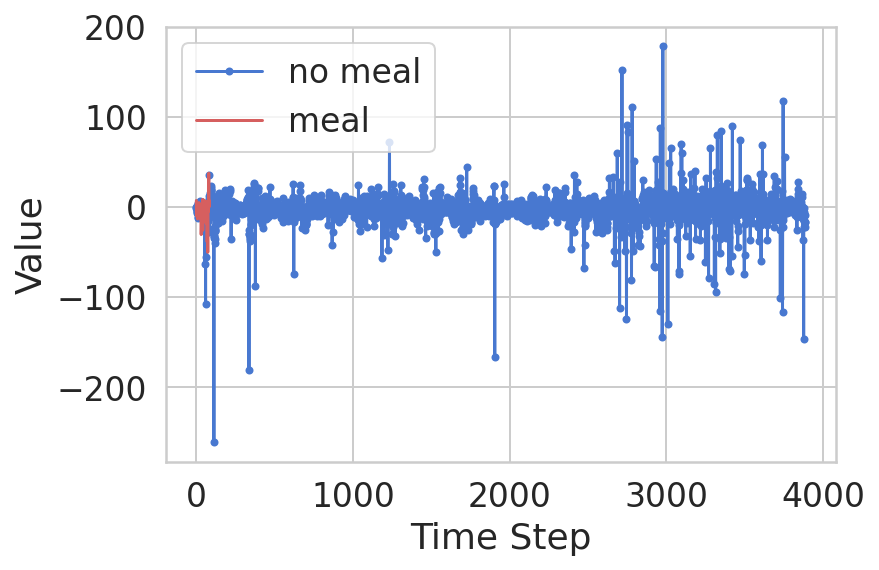

In [21]:
no_meal_rounded = [round(num, 4) for num in dic_differece[0]]

meal_rounded = [round(num, 4) for num in dic_differece[1]]

plt.plot(no_meal_rounded, marker='.', label="no meal")
plt.plot(meal_rounded, 'r', label="meal")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [22]:
# plot_difference = m

In [ ]:
# dict_count_occurences_of_meal = {}

# for val in meal_rounded:
#     if val in dict_count_occurences_of_meal:
#         dict_count_occurences_of_meal[val] += 1
#     else:
#         dict_count_occurences_of_meal[val] = 1

# print(sorted(dict_count_occurences_of_meal.items(), key=lambda x: x[1], reverse=True))

In [ ]:
# dict_count_occurences_of_no_meal = {}

# for val in no_meal_rounded:
#     if val in dict_count_occurences_of_meal:
#         dict_count_occurences_of_no_meal[val] += 1
#     else:
#         dict_count_occurences_of_no_meal[val] = 1

# print(sorted(dict_count_occurences_of_no_meal.items(), key=lambda x: x[1], reverse=True))